**Movie Recomender**

We use python to create a "movie tinder" game where users are prompted with movies and give ratings. We then use a Hybrid Neural Network-Based model to predict more movies the user would like

**First import the required libraries**

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

***Load and wrangle the data:***

In [2]:
# Load 1,000,000 ratings from the 20m dataset
ratings = pd.read_csv("rating_20m.csv").sample(n=1_000_000, random_state=42).reset_index(drop=True)

# Find movies that are within the ratings
sampled_movie_ids = ratings['movieId'].unique()

# Subset movies to include only sampled_movie_ids
movies = pd.read_csv("movie_20m.csv")
movies = movies[movies['movieId'].isin(sampled_movie_ids)].reset_index(drop=True)

# Subset tags to include only those associated with sampled_movie_ids
tags = pd.read_csv("tag_20m.csv")
tags = tags[tags['movieId'].isin(sampled_movie_ids)].reset_index(drop=True)

# Merge tags into movies by concatenating all tags for each movie
tags['tag'] = tags['tag'].astype(str)
tags_grouped = tags.groupby('movieId')['tag'].apply(' '.join).reset_index()
movies = pd.merge(movies, tags_grouped, on='movieId', how='left')
movies['tag'] = movies['tag'].fillna('')  # Replace NaN with empty string

# Combine genres and tags into a single feature for TF-IDF
movies['combined_features'] = movies['genres'] + ' ' + movies['tag']

# Encode userId and movieId as strings (required for TensorFlow models)
ratings['user_id'] = ratings['userId'].astype(str)
ratings['movie_id'] = ratings['movieId'].astype(str)
movies['movie_id'] = movies['movieId'].astype(str)

## Find the top 100 most popular movies ##
# Compute 'rating_count' by grouping and summarizing ratings
rating_counts = ratings.groupby('movie_id').size().reset_index(name='rating_count')

# Merge 'rating_count' into the movies DataFrame
movies = movies.merge(rating_counts, on='movie_id', how='left')

# Sort movies by 'rating_count' in descending order to identify top 100
top_100 = movies.sort_values("rating_count", ascending=False).head(100).reset_index(drop=True)

# Create a separate DataFrame for all movies
movies_all = movies.reset_index(drop=True)

# Assign unique integer indices to movie_ids (for both all movies and top 100)
unique_movies_all = movies_all['movie_id'].unique().tolist()
movie_id_to_int_all = {movie_id: idx for idx, movie_id in enumerate(unique_movies_all)}
int_to_movie_id_all = {idx: movie_id for movie_id, idx in movie_id_to_int_all.items()}
movies_all['movie_index'] = movies_all['movie_id'].map(movie_id_to_int_all)

# Similarly, create mapping for top_100 movies
unique_movies_top_100 = top_100['movie_id'].unique().tolist()
movie_id_to_int_top_100 = {movie_id: idx for idx, movie_id in enumerate(unique_movies_top_100)}
int_to_movie_id_top_100 = {idx: movie_id for movie_id, idx in movie_id_to_int_top_100.items()}
top_100['movie_index'] = top_100['movie_id'].map(movie_id_to_int_top_100)

# Initialize TF-IDF Vectorizer and fit on all movies' combined features
tfidf_all = TfidfVectorizer(stop_words='english')
tfidf_matrix_all = tfidf_all.fit_transform(movies_all['combined_features'])

# Convert TF-IDF matrix to a dense numpy array for embedding lookup
tfidf_dense_all = tfidf_matrix_all.toarray()  # Shape: (num_movies_all, num_features)

# Create TF-IDF matrix for top 100 movies by selecting corresponding rows from tfidf_dense_all
top_100_movie_ids = top_100['movie_id'].tolist()
top_100_indices_in_all = movies_all[movies_all['movie_id'].isin(top_100_movie_ids)]['movie_index'].values

# Extract the TF-IDF vectors for top 100 movies
tfidf_dense_top_100 = tfidf_dense_all[top_100_indices_in_all]

# Assign 'movie_index' for top_100 movies to align with their positions in tfidf_dense_top_100
# Reset 'movie_index' in top_100 to range from 0 to 99
top_100 = top_100.reset_index(drop=True)
top_100['movie_index'] = top_100.index

# Update 'movie_index_all' in movies_all for consistency
movies_all = movies_all.reset_index(drop=True)
movies_all['movie_index'] = movies_all.index


# Split ratings into training and testing sets (80% train, 15% test, 5% holdout perhaps)
train_ratings, test_ratings = train_test_split(
    ratings[['user_id', 'movie_id', 'rating']],
    test_size=0.15,
    random_state=42
)

# Create a list of unique movie IDs and map them to integer indices for the full dataset
unique_movies = movies_all['movie_id'].unique().tolist()
movie_id_to_int = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}
int_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_int.items()}

# Assign integer indices to movie_ids in movies_all DataFrame
movies_all['movie_index'] = movies_all['movie_id'].map(movie_id_to_int)

# Print dataset statistics
print(f"Number of movies (all): {tfidf_dense_all.shape[0]}")
print(f"Number of TF-IDF features (all): {tfidf_dense_all.shape[1]}")
print(f"Number of top 100 movies: {top_100.shape[0]}")
print(f"Number of training ratings: {train_ratings.shape[0]}")
print(f"Number of testing ratings: {test_ratings.shape[0]}")


Number of movies (all): 15374
Number of TF-IDF features (all): 21761
Number of top 100 movies: 100
Number of training ratings: 850000
Number of testing ratings: 150000


***Create the hybrid model***

In [6]:
train_ratings["target_rating"] = train_ratings["rating"]
test_ratings["target_rating"] = test_ratings["rating"]

BATCH_SIZE = 32
EPOCHS = 4
STEPS_PER_EPOCH =  len(train_ratings) // BATCH_SIZE
VALIDATION_STEPS = len(test_ratings) // BATCH_SIZE

tfidf_tensor = tf.constant(tfidf_dense_all, dtype=tf.float32)  # shape: (num_movies, num_features)


# Model Definition
# ============================================================

def create_hybrid_model(num_features, dropout_rate=0.3, l2_reg=0.001):
    """
    Creates a hybrid model with:
      - Non-trainable embedding of TF-IDF vectors
      - Dense layers with dropout, L2, batch norm
      - Scaled sigmoid output [1, 5] using non-trainable Dense layer
    """

    # Embedding layer with TF-IDF vectors as weights, trainable=False
    embedding_layer = layers.Embedding(
        input_dim=tfidf_dense_all.shape[0],
        output_dim=num_features,
        embeddings_initializer=tf.keras.initializers.Constant(tfidf_dense_all),
        trainable=False,  # Keep as False to avoid memory warnings
        name="tfidf_embedding"
    )

    # Inputs
    rated_movie_indices = layers.Input(shape=(None,), dtype=tf.int32, name="rated_movie_indices")
    rated_ratings       = layers.Input(shape=(None,), dtype=tf.float32, name="rated_ratings")
    target_movie_index  = layers.Input(shape=(1,),   dtype=tf.int32,   name="target_movie_index")

    # Embeddings for rated movies: shape (batch_size, num_rated, num_features)
    rated_movie_embeddings = embedding_layer(rated_movie_indices)

    # Expand dims for rated_ratings -> (batch_size, num_rated, 1)
    rated_ratings_expanded = layers.Reshape((-1, 1))(rated_ratings)

    # Multiply embeddings by rated_ratings
    weighted_embeddings = layers.Multiply()([rated_movie_embeddings, rated_ratings_expanded])

    # Average to get user embedding: shape (batch_size, num_features)
    user_embedding = layers.GlobalAveragePooling1D()(weighted_embeddings)

    # TF-IDF for target movie: shape (batch_size, 1, num_features)
    target_movie_embedding = embedding_layer(target_movie_index)
    # Reshape -> (batch_size, num_features)
    target_movie_embedding = layers.Reshape((num_features,))(target_movie_embedding)

    # Concatenate -> (batch_size, 2*num_features)
    concatenated = layers.Concatenate()([user_embedding, target_movie_embedding])

    # Batch Norm
    bn1 = layers.BatchNormalization()(concatenated)

    # Dense layers (Dropout, L2, BN)
    dense1 = layers.Dense(512, activation="relu", kernel_regularizer=l2(l2_reg))(bn1)
    bn2 = layers.BatchNormalization()(dense1)
    dropout1 = layers.Dropout(dropout_rate)(bn2)

    dense2 = layers.Dense(256, activation="relu", kernel_regularizer=l2(l2_reg))(dropout1)
    bn3 = layers.BatchNormalization()(dense2)
    dropout2 = layers.Dropout(dropout_rate)(bn3)

    dense3 = layers.Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(dropout2)
    bn4 = layers.BatchNormalization()(dense3)
    dropout3 = layers.Dropout(dropout_rate)(bn4)

    dense4 = layers.Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(dropout3)
    bn5 = layers.BatchNormalization()(dense4)
    dropout4 = layers.Dropout(dropout_rate)(bn5)

    # Output: Sigmoid -> (0,1)
    output_sigmoid = layers.Dense(1, activation="sigmoid")(dropout3)

    # Scale from [0,1] to [1,5] using a non-trainable Dense layer with fixed weights
    # Initialize Dense layer to perform: output = (sigmoid_output * 4) + 1
    scale_shift_layer = layers.Dense(
        1,
        activation="linear",
        use_bias=True,
        kernel_initializer=tf.keras.initializers.Constant([[4.0]]),
        bias_initializer=tf.keras.initializers.Constant([1.0]),
        trainable=False,
        name="scale_shift"
    )(output_sigmoid)

    # Build model
    model = Model(
        inputs=[rated_movie_indices, rated_ratings, target_movie_index],
        outputs=scale_shift_layer
    )

    # Compile with Huber Loss + Adam
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=Huber(delta=1.0),
        metrics=["mean_absolute_error"]
    )

    return model


# Create the Model
# ============================================================

num_features = tfidf_dense_all.shape[1]
model = create_hybrid_model(
    num_features=num_features,
    dropout_rate=0.3,
    l2_reg=0.001
)


# Data Generators
# ============================================================

def train_data_generator(train_ratings, movie_id_to_int):
    """
    Yields ((rated_movie_indices, rated_ratings, target_movie_index), target_rating).
    """
    for user_id, group in train_ratings.groupby("user_id"):
        rated_movies = group["movie_id"].tolist()
        ratings = group["target_rating"].tolist()
        if len(rated_movies) < 2:
            continue
        for i in range(len(rated_movies)):
            target_movie = rated_movies[i]
            target_rating = ratings[i]
            
            context_movies = rated_movies[:i] + rated_movies[i+1:]
            context_ratings = ratings[:i] + ratings[i+1:]
            if not context_movies:
                continue

            target_movie_idx = movie_id_to_int.get(target_movie, 0)
            context_movie_indices = [movie_id_to_int.get(mid, 0) for mid in context_movies]
            yield ((context_movie_indices, context_ratings, [target_movie_idx]), target_rating)


def train_generator():
    return train_data_generator(train_ratings, movie_id_to_int)

def validation_data_generator(test_ratings, movie_id_to_int):
    """
    Yields ((rated_movie_indices, rated_ratings, target_movie_index), target_rating).
    """
    for user_id, group in test_ratings.groupby("user_id"):
        rated_movies = group["movie_id"].tolist()
        ratings = group["target_rating"].tolist()
        if len(rated_movies) < 2:
            continue
        for i in range(len(rated_movies)):
            target_movie = rated_movies[i]
            target_rating = ratings[i]
            
            context_movies = rated_movies[:i] + rated_movies[i+1:]
            context_ratings = ratings[:i] + ratings[i+1:]
            if not context_movies:
                continue

            target_movie_idx = movie_id_to_int.get(target_movie, 0)
            context_movie_indices = [movie_id_to_int.get(mid, 0) for mid in context_movies]
            yield ((context_movie_indices, context_ratings, [target_movie_idx]), target_rating)


def val_generator():
    return validation_data_generator(test_ratings, movie_id_to_int)


# TensorFlow Dataset Creation
# ============================================================

train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_types=((tf.int32, tf.float32, tf.int32), tf.float32),
    output_shapes=(
        ((None,), (None,), (1,)),
        ()
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_types=((tf.int32, tf.float32, tf.int32), tf.float32),
    output_shapes=(
        ((None,), (None,), (1,)),
        ()
    )
)

train_dataset = (
    train_dataset
    .shuffle(10_000)
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=(
            ((None,), (None,), (1,)),
            ()
        ),
        padding_values=(
            (0, 0.0, 0),
            0.0
        )
    )
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    validation_dataset
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=(
            ((None,), (None,), (1,)),
            ()
        ),
        padding_values=(
            (0, 0.0, 0),
            0.0
        )
    )
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)


# Callbacks
# ============================================================

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce LR by half
    patience=3,  # Wait for 3 epochs with no improvement
    verbose=1,
    min_lr=1e-6
)

# Train
# ============================================================

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, reduce_lr]
)

model.save("hybrid_refactored_improved.keras")  # Save with a new filename to reflect improvements

Epoch 1/4
26562/26562 ━━━━━━━━━━━━━━━━━━━━ 1849s 70ms/step - loss: 0.7340 - mean_absolute_error: 0.7801 - val_loss: 0.6954 - val_mean_absolute_error: 1.0213 - learning_rate: 0.0010
Epoch 2/4
26562/26562 ━━━━━━━━━━━━━━━━━━━━ 1947s 73ms/step - loss: 0.4442 - mean_absolute_error: 0.7451 - val_loss: 0.4922 - val_mean_absolute_error: 0.8201 - learning_rate: 0.0010
Epoch 3/4
26562/26562 ━━━━━━━━━━━━━━━━━━━━ 1897s 71ms/step - loss: 0.4237 - mean_absolute_error: 0.7425 - val_loss: 0.4551 - val_mean_absolute_error: 0.7861 - learning_rate: 0.0010
Epoch 4/4
26562/26562 ━━━━━━━━━━━━━━━━━━━━ 1942s 73ms/step - loss: 0.4139 - mean_absolute_error: 0.7392 - val_loss: 0.4632 - val_mean_absolute_error: 0.7995 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.


**Some graphs to understand the model**

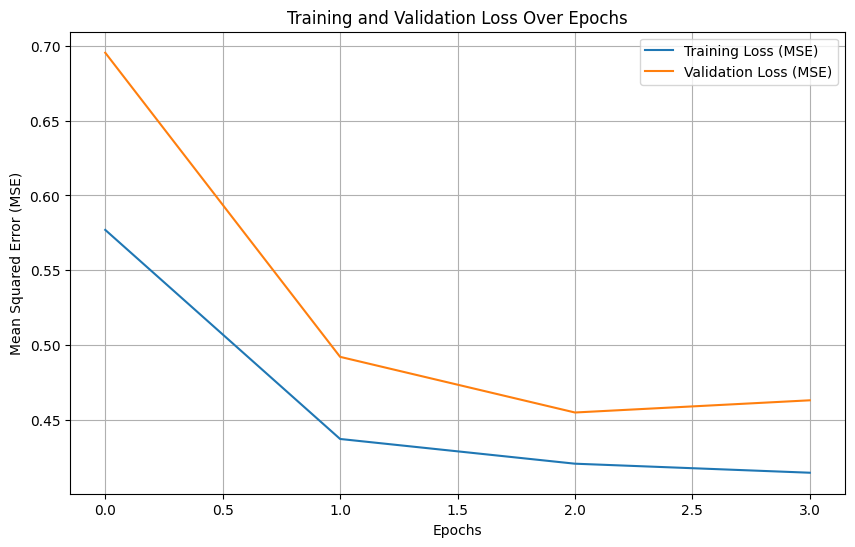

In [7]:
def plot_training_validation_loss(history):
    """
    Plots the training and validation loss over epochs.
    
    Parameters:
    - history: Keras History object returned by model.fit()
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_validation_loss(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2025-01-03 15:32:35.917930: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


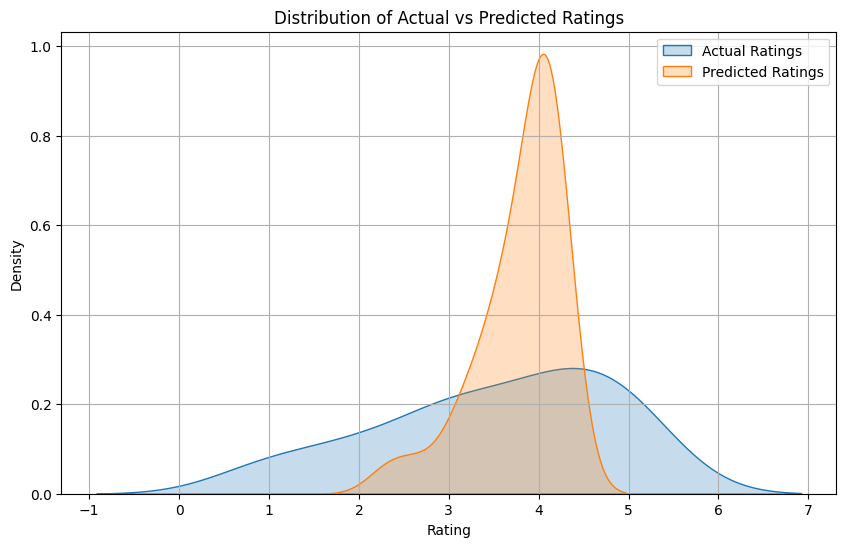

In [8]:
def plot_predicted_vs_actual(model, validation_dataset, num_samples=1000000):
    """
    Plots the distribution of predicted ratings vs actual ratings.
    
    Parameters:
    - model: Trained Keras model.
    - validation_dataset: tf.data.Dataset object for validation.
    - num_samples: Number of samples to plot.
    """
    actual = []
    predicted = []
    
    for inputs, targets in validation_dataset.take(1):
        preds = model.predict(inputs)
        actual.extend(targets.numpy())
        predicted.extend(preds.flatten())
    
    # Limit to num_samples
    actual = actual[:num_samples]
    predicted = predicted[:num_samples]
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(actual, label='Actual Ratings', fill=True)
    sns.kdeplot(predicted, label='Predicted Ratings', fill=True)
    plt.title('Distribution of Actual vs Predicted Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run code
model = keras.models.load_model('hybrid_refactored_improved.keras')  # Only run once otherwise will use ungodly amounts of memory
plot_predicted_vs_actual(model, validation_dataset, num_samples=100000)


**Interactive game**

In [ ]:
# model = keras.models.load_model('hybrid_refactored_improved.keras')


# Helper Functions

def get_top_n_popular_movies(movies_df, ratings_df, n=100):
    """
    Returns the top n popular movies based on the number of ratings.
    """
    rating_counts = ratings_df.groupby('movie_id').size().reset_index(name='rating_count')
    popular_movies = movies_df.merge(rating_counts, on='movie_id', how='left')
    popular_movies['rating_count'] = popular_movies['rating_count'].fillna(0)
    top_popular = popular_movies.sort_values(by='rating_count', ascending=False).head(n)
    return top_popular

def get_movie_index(title, movies_df):
    """
    Finds the movie_index in movies_df for the first movie whose title contains `title`.
    Case-insensitive substring match. Returns None if not found.
    """
    movie = movies_df[movies_df['title'].str.contains(title, case=False, regex=False)]
    if not movie.empty:
        return movie['movie_index'].values[0]
    else:
        return None 

def gather_user_profile_tfidf(user_rated_indices, tfidf_dense):
    """
    Computes the user's average TF-IDF profile from the movies they have rated.
    """
    if not user_rated_indices:
        return None
    user_profile = tfidf_dense[user_rated_indices].mean(axis=0).reshape(1, -1)
    return user_profile


def generate_model_recommendations(model, user_rated_movie_indices, user_rated_ratings, movies_df, top_n=5):
    """
    Generates the top_n recommendations using the hybrid model, excluding already-rated movies.
    """
    if not user_rated_movie_indices:
        return 

    rated_movie_indices_np = np.array([user_rated_movie_indices], dtype=np.int32)  # Shape: (1, num_rated)
    rated_ratings_np       = np.array([user_rated_ratings], dtype=np.float32)      # Shape: (1, num_rated)

    # All candidate movies
    all_movie_indices = movies_df['movie_index'].values
    # Exclude rated
    candidate_indices = all_movie_indices[~np.isin(all_movie_indices, user_rated_movie_indices)]

    # Batch predictions to handle large number of candidates
    batch_size = 1024
    predictions = []
    for i in range(0, len(candidate_indices), batch_size):
        batch = candidate_indices[i:i+batch_size]
        # Tile user ratings for each target movie in the batch
        rated_movie_tiled = np.tile(rated_movie_indices_np, (len(batch), 1))  # Shape: (batch_size, num_rated)
        rated_ratings_tiled = np.tile(rated_ratings_np, (len(batch), 1))      # Shape: (batch_size, num_rated)

        # Ensure target_movie_index is shaped correctly (batch_size, 1)
        target_movie_indices_batch = batch.reshape(-1, 1)  # Shape: (batch_size, 1)

        # Make predictions
        batch_preds = model.predict(
            [rated_movie_tiled, rated_ratings_tiled, target_movie_indices_batch],
            batch_size=batch_size,
            verbose=0  # Suppress prediction logs
        )
        predictions.extend(batch_preds.flatten())

    # Create a DataFrame with movie titles and predicted ratings
    recommendations = pd.DataFrame({
        'movie_index': candidate_indices,
        'predicted_rating': predictions
    })
    merged = pd.merge(recommendations, movies_df, on='movie_index', how='left')

    # Sort by predicted_rating descending and select top_n
    top_recs = merged.sort_values(by='predicted_rating', ascending=False).head(top_n)

    print("\nTop Recommendations Based on Model Predictions:")
    for _, row in top_recs.iterrows():
        print(f"{row['title']} - Predicted Rating: {row['predicted_rating']:.2f}")


# next_movie_to_rate Function
# =========================

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def next_movie_to_rate(movies, liked_movies, disliked_movies, tfidf_matrix, seen_movies):
    """
    Dynamically select the next movie to show based on user feedback.
    All movies are from the top 100 subset.

    Parameters:
    - movies (pd.DataFrame): DataFrame containing top 100 movies with 'movie_id' and other relevant columns.
    - liked_movies (list): List of movie_ids that the user has liked.
    - disliked_movies (list): List of movie_ids that the user has disliked.
    - tfidf_matrix (numpy.ndarray or scipy.sparse matrix): TF-IDF vectors corresponding to the 'movies' DataFrame.
    - seen_movies (list): List of movie_ids that the user has already seen/rated.

    Returns:
    - pd.Series: The next movie row to prompt the user for rating.
    - None: If there are no more unseen movies to rate.
    """
    # If it's truly the first iteration, pick randomly from top 100
    if not liked_movies and not disliked_movies and not seen_movies:
        return movies.sample(n=1).iloc[0]

    num_movies = len(movies)

    # Initialize similarity scores
    avg_liked_similarity = np.zeros(num_movies)
    avg_disliked_similarity = np.zeros(num_movies)

    # Build average similarity for liked movies
    if liked_movies:
        # Find positional indices of liked movies in the 'movies' DataFrame
        liked_indices = [i for i, m_id in enumerate(movies['movie_id']) if m_id in liked_movies]
        if liked_indices:
            liked_matrix = tfidf_matrix[liked_indices]  # shape: (#liked, num_features)
            # Compute cosine similarity between liked movies and all movies
            avg_liked_sim_all = cosine_similarity(liked_matrix, tfidf_matrix)  # shape: (#liked, num_movies)
            avg_liked_similarity = avg_liked_sim_all.mean(axis=0)  # shape: (num_movies,)

    # Build average similarity for disliked movie
    if disliked_movies:
        # Find positional indices of disliked movies in the 'movies' DataFrame
        disliked_indices = [i for i, m_id in enumerate(movies['movie_id']) if m_id in disliked_movies]
        if disliked_indices:
            disliked_matrix = tfidf_matrix[disliked_indices]  # shape: (#disliked, num_features)
            # Compute cosine similarity between disliked movies and all movies
            avg_disliked_sim_all = cosine_similarity(disliked_matrix, tfidf_matrix)  # shape: (#disliked, num_movies)
            avg_disliked_similarity = avg_disliked_sim_all.mean(axis=0)  # shape: (num_movies,)

    # --- Final adjusted scores: liked - disliked ---
    adjusted_scores = avg_liked_similarity - avg_disliked_similarity

    # --- Mark seen movies as -inf so they're never picked again ---
    if seen_movies:
        seen_indices = [i for i, m_id in enumerate(movies['movie_id']) if m_id in seen_movies]
        for idx in seen_indices:
            adjusted_scores[idx] = -np.inf

    # --- Pick best-scoring movie ---
    top_idx = np.argmax(adjusted_scores)
    if adjusted_scores[top_idx] == -np.inf:
        # All top 100 movies have been seen
        unseen = movies[~movies['movie_id'].isin(seen_movies)]
        if len(unseen) > 0:
            return unseen.sample(n=1).iloc[0]
        else:
            return None
    else:
        return movies.iloc[top_idx]



# Interactive Game Logic
# =====================

def start_realtime_game(movies_df, ratings_df, tfidf_dense):
    """
    Interactive loop:
      1) Show 1 random top-popular movie from top 100 for user rating.
      2) Then repeatedly pick next movie based on similarity to user's feedback.
      3) The user can type 'recommend' any time to get model-based recs.
      4) The user can type 'done' to exit.
    """
    print("Welcome to the Movie Recommendation Game!")
    user_rated_movie_indices = []
    user_rated_ratings       = []
    liked_movies             = []
    disliked_movies          = []
    seen_movies               = []

    # Pick exactly 1 random top-popular movie from top 100
    top_popular = top_100
    first_movie = top_popular.sample(n=1).iloc[0] 
    first_title = first_movie['title']
    first_id = first_movie['movie_id']
    first_index = first_movie['movie_index']
    while True:
        rating_input = input(f"\nPlease rate this popular movie '{first_title}' (1-5): ")
        if rating_input.strip().lower() == "done":
            print("Exiting. Goodbye!")
            return
        try:
            rating_val = float(rating_input)
            if 1 <= rating_val <= 5:
                user_rated_movie_indices.append(first_index)
                user_rated_ratings.append(rating_val)
                seen_movies.append(first_id)
                # Categorize as liked or disliked based on rating
                if rating_val >= 4:
                    liked_movies.append(first_id)
                elif rating_val <= 2:
                    disliked_movies.append(first_id)
                break
            else:
                print("Rating must be between 1 and 5.")
        except ValueError:
            print("Invalid input. Enter a number between 1 and 5, or type 'done' to exit.")

    # Interactive loop for subsequent movies
    print("\nNow we will pick subsequent movies based on your feedback.\n")

    while True:

        next_movie = next_movie_to_rate(top_100, liked_movies, disliked_movies, tfidf_dense, seen_movies)
        if next_movie is None:
            print("No more movies to rate. Type 'recommend' to get final recommendations or 'done' to exit.")
            user_cmd = input("> ").strip().lower()
            if user_cmd == "recommend":
                generate_model_recommendations(model, user_rated_movie_indices, user_rated_ratings, movies_df, top_n=5)
            elif user_cmd == "done":
                break
            else:
                print("Unrecognized command. Please type 'recommend' or 'done'.")
            continue

        next_title = next_movie['title']
        next_id = next_movie['movie_id']
        next_index = next_movie['movie_index']

        # Ask user for rating or a command
        user_input = input(f"\nNext suggested movie: {next_title}\nRate 1-5, type 'recommend' to see recommendations, or 'done' to exit: ").strip().lower()

        
        if user_input == "done":
            print("Exiting. Goodbye!")
            break
        elif user_input == "recommend":
            # Show recommendations based on current data
            generate_model_recommendations(model, user_rated_movie_indices, user_rated_ratings, movies_df, top_n=5)
            continue  
        else:
            try:
                rating_val = float(user_input)
                if 1 <= rating_val <= 5:
                    user_rated_movie_indices.append(next_index)
                    user_rated_ratings.append(rating_val)
                    seen_movies.append(next_id)
                    # Categorize as liked or disliked based on rating
                    if rating_val >= 4:
                        liked_movies.append(next_id)
                    elif rating_val <= 2:
                        disliked_movies.append(next_id)
                else:
                    print("Rating must be between 1 and 5. Skipping this movie.")
            except ValueError:
                print("Invalid input. Skipping this movie.")

    # After exiting the loop, provide final recommendations
    print("\nThanks for playing the Movie Recommendation Game!")
    print("Here are final recommendations if you'd like:\n")
    generate_model_recommendations(model, user_rated_movie_indices, user_rated_ratings, movies_df, top_n=5)





start_realtime_game(movies_all, ratings, tfidf_dense_top_100)

Welcome to the Movie Recommendation Game!



Please rate this popular movie 'Mission: Impossible (1996)' (1-5):  1



Now we will pick subsequent movies based on your feedback.




Next suggested movie: Independence Day (a.k.a. ID4) (1996)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Godfather, The (1972)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  3

Next suggested movie: Willy Wonka & the Chocolate Factory (1971)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  2

Next suggested movie: Lord of the Rings: The Fellowship of the Ring, The (2001)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Sixth Sense, The (1999)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Terminator, The (1984)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Lion King, The (1994)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  2

Next suggested movie: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (198

Invalid input. Skipping this movie.



Next suggested movie: Ace Ventura: Pet Detective (1994)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Apollo 13 (1995)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Alien (1979)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Twister (1996)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  3

Next suggested movie: Dumb & Dumber (Dumb and Dumber) (1994)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Goodfellas (1990)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  5

Next suggested movie: One Flew Over the Cuckoo's Nest (1975)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit

Invalid input. Skipping this movie.



Next suggested movie: Finding Nemo (2003)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Sleepless in Seattle (1993)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Toy Story (1995)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Reservoir Dogs (1992)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  3

Next suggested movie: Fugitive, The (1993)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Mask, The (1994)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Clear and Present Danger (1994)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  1

Next suggested movie: Back to the Future (1985)
Rate 1-5, type 'recommend' to see recommendations, or 'done' to exit:  5

Next suggested movie: Schindler's List (1993)
Ra

No more movies to rate. Type 'recommend' to get final recommendations or 'done' to exit.


>  recommend



Top Recommendations Based on Model Predictions:
Diabolique (Les diaboliques) (1955) - Predicted Rating: 4.28
Wages of Fear, The (Salaire de la peur, Le) (1953) - Predicted Rating: 4.27
Treasure of the Sierra Madre, The (1948) - Predicted Rating: 4.26
Lady Vanishes, The (1938) - Predicted Rating: 4.25
Grapes of Wrath, The (1940) - Predicted Rating: 4.25
No more movies to rate. Type 'recommend' to get final recommendations or 'done' to exit.
